In [60]:
!pip install pyro-ppl==1.8.4
!pip install pip install numpyro==0.11.0
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import annotations

from collections.abc import Sequence
import time
from typing import Any

import jax
import jax.numpy as jnp
from jax import random, vmap
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as npdist
from numpyro.infer import MCMC, NUTS, BarkerMH
import numpy as np
import torch
from torch import nn, optim, Tensor
from tqdm.auto import tqdm




data = pd.read_csv('/content/drive/MyDrive/aggregated_data_10_minute_intervals.csv')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
data.index = pd.DatetimeIndex(data["threshold_time_ms"])
#data

In [62]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# # fit scaler on data
# scaler.fit(np.array(data["mean"]).reshape(-1, 1))
# # apply transform
# data["mean_scaled"] = scaler.transform(np.array(data["mean"]).reshape(-1, 1))
# #data

In [63]:
data["y"] = data["mean"].shift(-1)
#data[:20]

In [64]:
Data = pd.DataFrame()
X_list = []
for i in [1,2,3,4,5,6,7,8,9,10,15,20,50,100]:
  Data[f"prev_{i - 1}"] = data["y"].shift(i)
  X_list.append(f"prev_{i - 1}")
Data["y"] = data["y"]
Data = Data.dropna()
Data

,prev_0,prev_1,prev_2,prev_3,prev_4,prev_5,prev_6,prev_7,prev_8,prev_9,prev_14,prev_19,prev_49,prev_99,y
threshold_time_ms,,,,,,,,,,,,,,,
2021-06-01 16:40:00,36187.860646,36272.588577,36280.200408,36250.286456,36166.708406,36200.727578,36219.800113,36227.068545,36306.079087,36298.414475,36810.236896,36851.114788,36141.371999,37557.626392,35890.452447
2021-06-01 16:50:00,35890.452447,36187.860646,36272.588577,36280.200408,36250.286456,36166.708406,36200.727578,36219.800113,36227.068545,36306.079087,36858.994873,37194.645595,36084.375153,37604.831633,35915.237358
2021-06-01 17:00:00,35915.237358,35890.452447,36187.860646,36272.588577,36280.200408,36250.286456,36166.708406,36200.727578,36219.800113,36227.068545,36840.234066,37013.531913,36161.732779,37680.924508,35856.460554
2021-06-01 17:10:00,35856.460554,35915.237358,35890.452447,36187.860646,36272.588577,36280.200408,36250.286456,36166.708406,36200.727578,36219.800113,36600.546694,37140.282801,36260.528734,37727.027529,35905.935342
2021-06-01 17:20:00,35905.935342,35856.460554,35915.237358,35890.452447,36187.860646,36272.588577,36280.200408,36250.286456,36166.708406,36200.727578,36457.918804,37022.280233,36228.221529,37748.770742,36009.219826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-24 23:00:00,42914.171541,43008.154115,42858.197773,42811.343775,42896.450686,42898.911745,42856.244908,42955.753731,43004.122196,43030.717387,42874.237362,42293.718752,42409.287863,44303.385630,42892.151458
2021-09-24 23:10:00,42892.151458,42914.171541,43008.154115,42858.197773,42811.343775,42896.450686,42898.911745,42856.244908,42955.753731,43004.122196,42895.034400,42384.282404,42310.898325,44216.082850,42918.442794
2021-09-24 23:20:00,42918.442794,42892.151458,42914.171541,43008.154115,42858.197773,42811.343775,42896.450686,42898.911745,42856.244908,42955.753731,43000.730413,42475.340669,42257.755546,44193.215142,42725.645824


In [65]:
# Define the splits
train_split = int(len(Data) * 0.7) 

# Create the train set
train_x, train_y = (torch.tensor(np.array(Data.iloc[:train_split][X_list])).type(torch.float32), 
                    torch.tensor(np.array(Data.iloc[:train_split]["y"])).type(torch.float32))

# Create the test set
test_x, test_y = (torch.tensor(np.array(Data.iloc[train_split:][X_list])).type(torch.float32), 
                  torch.tensor(np.array(Data.iloc[train_split:]["y"])).type(torch.float32))





In [66]:
def plot_posterior(test_x, test_y, y_samples: np.ndarray, f_samples: np.ndarray | None = None
                   ) -> None:
    """Plots samples from posterior, along with ±1 std. uncertainty bands.
    y = f + \eps

    Args:
        y_samples: samples of y from posterior
        f_samples: samples of f(x) from posterior, optional
    """
    # calculate predictive uncertainty
    pred_mean = y_samples.mean(axis=0)
    pred_std = y_samples.std(axis=0)
    pred_var = pred_std ** 2
    print('avg. predictive uncertainty:', pred_var.mean())

    if f_samples is not None:
        # calculate model uncertainty
        model_mean = f_samples.mean(axis=0)
        model_std = f_samples.std(axis=0)
        model_var = model_std ** 2
        print('avg. model uncertainty:', model_var.mean())

        # approximate data uncertainty = predictive variance - model variance
        data_var = np.abs(pred_var - model_var)
        data_std = np.sqrt(data_var)
        print('avg. data uncertainty:', data_var.mean())
    x = torch.linspace(-1, 1.5, len(test_y))
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(5, 4))
    ax.plot(x, test_y,c='black', label='true f')
    #ax.scatter(torch.linspace(-1, 1.5, len(train_x)).reshape(-1, 1) , train_y, marker='x', c='green', label='training')
    
    
    if f_samples is None:
        # plot predictive uncertainty
        ax.fill_between(x, pred_mean + pred_std, pred_mean - pred_std,
                        alpha=0.5, label='predictive uncertainty')
    else:
        # plot model uncertainty
        ax.fill_between(x, model_mean + model_std, model_mean - model_std,
                        alpha=0.5, label='model uncertainty')

        # plot data uncertainty
        ax.fill_between(x, model_mean + model_std, model_mean + pred_std,
                        color='red', alpha=0.5, label='data uncertainty')
        ax.fill_between(x, model_mean - model_std, model_mean - pred_std,
                        color='red', alpha=0.5)

    ax.legend()

In [67]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroParam, PyroSample


class BNN(PyroModule):
    def __init__(self, dims: Sequence[int]):
        super().__init__()
        layers = []
        for i in range(len(dims) - 1):
            layer = PyroModule[nn.Linear](dims[i], dims[i+1])
            layer.weight = PyroSample(
                prior=dist.Normal(0, 1).expand([dims[i+1], dims[i]]).to_event(2))
            layer.bias = PyroSample(
                prior=dist.Normal(0, 1).expand([dims[i+1]]).to_event(1))
            layers.append(layer)
        self.layers = PyroModule[torch.nn.ModuleList](layers)
        self.relu = nn.ReLU()

    def forward(self, x: Tensor) -> Tensor:
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i != len(self.layers) - 1:
                x = self.relu(x)
        return x


class BNNRegressor(PyroModule):
    def __init__(self, dims: Sequence[int]):
        super().__init__()
        assert dims[-1] == 1
        self.bnn = BNN(dims)

    def forward(self, x: Tensor, y: Tensor | None = None) -> Tensor:
        mu = self.bnn(x).squeeze()
        sigma = pyro.sample("sigma", dist.Uniform(0, 0.5))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return mu

In [68]:
bnn = BNNRegressor(dims=[14, 20, 20, 1])
guide = pyro.infer.autoguide.AutoDiagonalNormal(bnn)
adam = pyro.optim.Adam({"lr": 1e-3})
svi = pyro.infer.SVI(bnn, guide, adam, loss=pyro.infer.Trace_ELBO())

def train(svi, train_x, train_y):
  pyro.clear_param_store()
  num_iters = 20_000
  pbar = tqdm(range(num_iters))
  for i in pbar:
      elbo = svi.step(train_x, train_y)
      if (i+1) % 10 == 0:
          pbar.set_description(f"Elbo loss: {elbo / len(train_x):.3f}")
      #if elbo < -100:
      #    break

def predict(bnn, guide, test_x):
  predictive = pyro.infer.Predictive(bnn, guide=guide, num_samples=100, return_sites=['_RETURN', 'obs'])
  samples = predictive(test_x, y=None)
  f_samples = samples['_RETURN'].detach().numpy()
  y_samples = samples['obs'].detach().numpy()
  return y_samples, f_samples

train(svi, train_x, train_y)

  0%|          | 0/20000 [00:00<?, ?it/s]

avg. predictive uncertainty: 1533802.9
avg. model uncertainty: 1533801.2
avg. data uncertainty: 93.53532


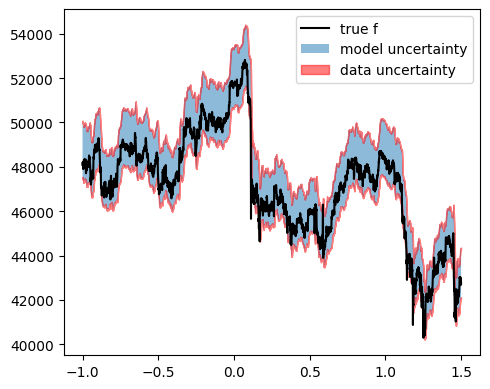

In [69]:
y_samples, f_samples = predict(bnn, guide, test_x)
    

plot_posterior(test_x, test_y, y_samples, f_samples)

In [70]:
# fake = [[np.random.randint(10,100) for i in range(14)] for j in range(5)]
# test_y = [50,50,50,50,50]
# test_x_fake = torch.tensor(np.array(fake)).type(torch.float32)
# y_samples, f_samples = predict(bnn, guide, test_x_fake)
# plot_posterior(test_x_fake, test_y, y_samples, f_samples)

In [71]:
def coverage(y: np.ndarray, pred_low: np.ndarray, pred_high: np.ndarray) -> float:
    """Calculates coverage.

    Args
    - y: array of shape [n], labels
    - pred_low: array of shape [n], predicted (α/2)-quantile
    - pred_high: array of shape [n], predicted (1-α/2)-quantile

    Returns: float, coverage rate
    """
    assert len(y) == len(pred_low)
    assert len(y) == len(pred_high)
    cov = 0

    for i in range(len(y)):
      if y[i] >= pred_low[i] and y[i] <= pred_high[i]:
        cov += 1
    cov = cov / len(y)
    return cov

In [72]:
from tqdm import tqdm
print(y_samples)
lower = np.min(y_samples, axis = 0)
upper = np.max(y_samples, axis = 0)


print(coverage(np.array(test_y[1000:]), lower[1000:], upper[1000:]))
out1 = pd.DataFrame()
out1["lower"] = lower[1000:]
out1["upper"] = upper[1000:]
out1["pred"] = y_samples.mean(axis=0)[1000:]
out1.index = Data.iloc[train_split:].index[1000:]
out1
out1.to_csv("bnn_results.csv")

[[49009.27  48981.957 48934.227 ... 43389.07  43344.387 43330.023]
 [48811.24  48781.895 48725.695 ... 43214.76  43172.805 43163.93 ]
 [51327.633 51296.824 51244.098 ... 45449.258 45401.465 45387.484]
 ...
 [48549.906 48521.46  48471.87  ... 43002.402 42959.188 42943.73 ]
 [50313.773 50304.73  50246.953 ... 44463.22  44411.61  44388.008]
 [47599.184 47573.86  47524.777 ... 42152.78  42105.734 42092.984]]
0.9982886480319453


In [73]:
def nonconformity_score(y: np.ndarray, q_low: np.ndarray, q_high: np.ndarray) -> np.ndarray:
    """Calculates nonconformity score for conformalized quantile regression.

    Args
    - y: array of shape [n], labels
    - q_low: array of shape [n], predicted (α/2)-quantile
    - q_high: array of shape [n], predicted (1-α/2)-quantile

    Returns: array of shape [n], nonconformity scores
    """
    ##### YOUR CODE HERE (~1 line) #####
    scores = []
    for i in range(len(y)):
      score = max(q_low[i] - y[i], y[i] - q_high[i])
      scores.append(score)
    return scores
    ##### END YOUR CODE #####
    


def cqr(test, low, high, alpha) -> tuple[np.ndarray, np.ndarray]:
    """Performs conformal calibration and returns the prediction intervals.

    Args
    - qr_low, qr_high: sklearn QuantileRegressor models for predicting
        low / high quantiles, respectively
    - X_cal: array of shape [n, d], calibration set features
    - y_cal: array of shape [n], calibration set labels
    - alpha: float, desired error rate
    - test_pred_low, test_pred_high: arrays of shape [n_test], uncalibrated
        predicted quantiles on the test set

    Returns: (pred_low, pred_high), calibrated lower and upper quantiles
    """
    # 1. Call the nonconformity_score() function to calculate nonconformity scores
    #      on the calibration set
    # 2. Set qhat to be the ceil((n+1)*(1-alpha))/n quantile of the nonconformity scores
    # 3. Adjust the calibration intervals as
    #      C(x) = [t_{α/2}(x) − qhat, t_{1−α/2}(x) + qhat]

    ##### YOUR CODE HERE (~6 lines) #####
    n = 1000
    y_cal = test[:n]
    low_cal = low[:n]
    high_cal = high[:n]

    s = nonconformity_score(y_cal, low_cal, high_cal)
    qhat = np.quantile(s, np.ceil((n+1) * (1- alpha))/n)
    pred_low = low - qhat
    pred_high = high + qhat
    
    
    ##### END YOUR CODE #####
    return (pred_low[n:], pred_high[n:])

In [74]:
calibrated_y_pred_low, calibrated_y_pred_high = cqr(
    np.array(test_y), lower, upper, 0.1)

# check post-calibration coverage
print(coverage(np.array(test_y[1000:]), calibrated_y_pred_low, calibrated_y_pred_high))

0.8471192241871078


In [75]:
out2 = pd.DataFrame()
out2["lower"] = calibrated_y_pred_low
out2["upper"] = calibrated_y_pred_high
out2["pred"] = test_y[1000:]
out2.index = Data.iloc[train_split:].index[1000:]
out2
out2.to_csv("conformal_bnn_results.csv")

In [76]:
data

,threshold_time_ms,open,close,high,low,mean,y
threshold_time_ms,,,,,,,
2021-06-01 00:00:00,2021-06-01 00:00:00,37260.955,37556.725,37670.765,37113.575,37478.248894,37557.626392
2021-06-01 00:10:00,2021-06-01 00:10:00,37559.935,37493.535,37654.445,37478.255,37557.626392,37604.831633
2021-06-01 00:20:00,2021-06-01 00:20:00,37482.405,37733.200,37747.745,37465.580,37604.831633,37680.924508
2021-06-01 00:30:00,2021-06-01 00:30:00,37731.905,37762.095,37779.995,37570.005,37680.924508,37727.027529
2021-06-01 00:40:00,2021-06-01 00:40:00,37762.095,37655.665,37798.985,37650.005,37727.027529,37748.770742
...,...,...,...,...,...,...,...
2021-09-24 23:10:00,2021-09-24 23:10:00,42854.565,42949.675,42949.715,42839.415,42892.151458,42918.442794
2021-09-24 23:20:00,2021-09-24 23:20:00,42949.675,42881.335,42965.445,42861.915,42918.442794,42725.645824
2021-09-24 23:30:00,2021-09-24 23:30:00,42881.335,42672.665,42881.335,42620.005,42725.645824,42682.211311


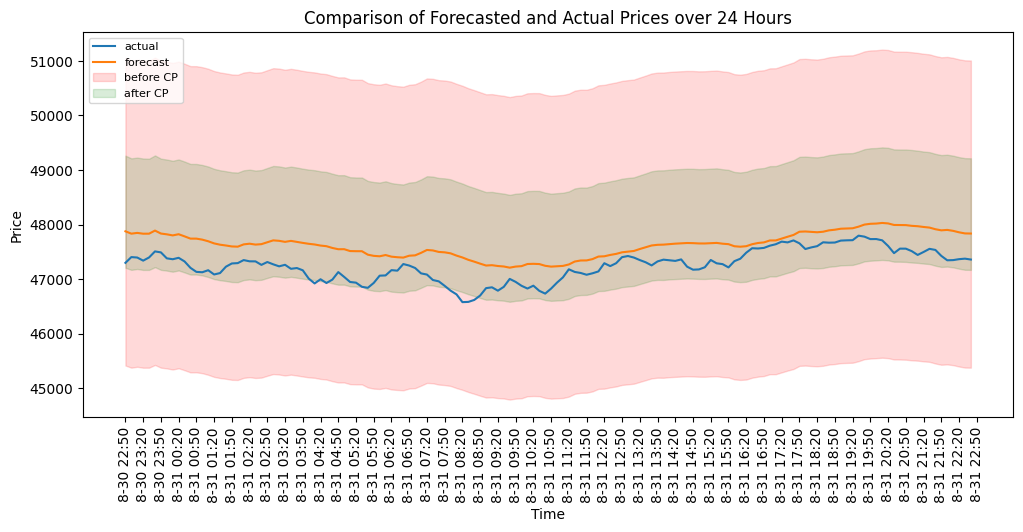

In [77]:
test = Data.iloc[train_split:]["y"]
df = out1
times = data.iloc[train_split:].iloc[1000:1145:3]['threshold_time_ms'].values
hours = [str(s)[6:-3] for s in times]

import matplotlib.pyplot as plt
# Make as pandas series
fc_series = pd.Series(df["pred"][0:].values, index=test.index[1000:])
lower_series = pd.Series(df["lower"][0:].values, index=test.index[1000:])
upper_series = pd.Series(df["upper"][0:].values, index=test.index[1000:])

lower_seriesCP = pd.Series(calibrated_y_pred_low, index=test.index[1000:])
upper_seriesCP = pd.Series(calibrated_y_pred_high, index=test.index[1000:])

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train, label='training')
plt.plot(test.index[1000:1144], test[1000:1144], label='actual')
plt.plot(test.index[1000:1144], fc_series[:144], label='forecast')



plt.fill_between(lower_series.index[:144], lower_series[:144], upper_series[:144], 
                 color='red', alpha=.15, label = "before CP")

plt.fill_between(lower_series.index[:144], lower_seriesCP[:144], upper_seriesCP[:144], 
                 color='green', alpha=.15, label = "after CP")

plt.xlabel("Time")
plt.ylabel("Price")
plt.title('Comparison of Forecasted and Actual Prices over 24 Hours')
plt.xticks(test.index[1000:1145:3], hours,
       rotation=90) 
plt.legend(loc='upper left', fontsize=8)
# fig = plt.gcf()
# fig.set_facecolor('white')
# # Remove the grid
# plt.style.use("default")

# plt.grid(False)
plt.show()

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
